# Using geopandas and folium to create webmaps
- **[Here is the code](https://anaconda.org/debboutr/qa_lakecat) to create [this map](http://debboutr.github.io/f_map.html) and describe the methods used in this analysis for [LakeCat](https://github.com/USEPA/LakeCat)**


- **created by Rick Debbout :** <debboutr@gmail.com>

In [1]:
from IPython.display import Image, HTML
% matplotlib inline
import os
import folium
import pandas as pd
import geopandas as gpd
DL_dir = '/home/rick/Downloads/SpatialData'

In [8]:
def color(pct):
    if pct <= 50:
        col=('green','ok')
    elif 50 < pct <= 75:
        col=('blue','remove')
    elif pct > 75:
        col=('darkred','ban-circle')
    return col  

miss = gpd.GeoDataFrame.from_file("%s/miss.json" % DL_dir).to_crs({'init' :'epsg:4326'})
one = miss.ix[miss.COMID == 22827340]
extent = one.unary_union.bounds
lat_Center = 39.4
lon_Center = (extent[0] + extent[2]) / 2
f_map=folium.Map(location=[lat_Center , lon_Center],zoom_start=12,tiles="Stamen Terrain", control_scale=True)
fg=folium.FeatureGroup(name="Lake Points")
for lat,lon,name,pct in zip(miss['geometry'].centroid.map(lambda p: p.y),miss['geometry'].centroid.map(lambda p: p.x),miss['COMID'],miss['PCT']):
    html="""
    <p>NHD Waterbody <b>COMID</b>: %s</p><br>
    <p>Percent uncovered: <b>%s %%</b></p>
    """ % (int(name), pct)
    iframe = folium.element.IFrame(html=html, width=300, height=120)
    fg.add_child(folium.Marker(location=[lat,lon],popup=folium.Popup(iframe),
                                   icon=folium.Icon(icon_color='white', color=color(pct)[0], icon=color(pct)[1])))
    f_map.add_child(fg)
f_map.add_child(folium.GeoJson(data=open('%s/lks.json' % DL_dir),
                name='NHD Lake',
                style_function=lambda x: {'fillColor':'blue', 
                                          'fill_opacity': 0.2, 
                                          'color':'none'}))
f_map.add_child(folium.GeoJson(data=open('%s/bsn.json' % DL_dir),
                name='Catchment Basin',
                style_function=lambda x: {'fillColor':'grey', 
                                          'fill_opacity': 0.74,
                                          'color':'white'}))
f_map.add_child(folium.GeoJson(data=open('%s/miss.json' % DL_dir),
                name='Missed Area',
                style_function=lambda x: {'fillColor':'red', 
                                          'fill_opacity': 0.2, 
                                          'color':'none'}))
f_map.add_child(folium.LayerControl())

# <font color='#1a3300'>Overview of the Analysis</font>
**<font color='#1a3300'>The code in this notebook walks through the process of finding local lake basins with the on-network accumulation process. For each lake, we report the "catchment" statistics as a landscape summarization of the NHD Catchments associated by flowlines that hold the waterbodies COMID in the "WBAREACOMI" field. Using geopandas, we can do a unary_union with these catchments and compare the overlapping areas using the 'difference' method built in to geopandas. This script selects polys where we find less than 50% of the lake is covered by it's associated catchments and plots them with the folium package for a slippy map of each of the instances of poor coverage.</font>**

**<font color='#1a3300'>The image below depicts a lake with good coverage from the associated catchments (yellow). Notice in the lower center of the lake that there is a bit which isn't covered by the catchments. This is what we will be looking to find more of in this exercise. This was part of a QA check for the </font>**[LakeCat Dataset](https://github.com/USEPA/LakeCat)

<font color='#1a3300'><b><i>LakeCat</i></b> sumarizes landscape metrics for <b><i>lake/pond/reservoir</i></b> watersheds. In order to report an accurate local basin for each, an array of <b><i>NHDPlusV21 Catchments</i></b> are accumlated in cases where more than one needed to cover the lake polygon.</font>


<font color='#1a3300'><b><i>NHDPlusV21 Flowlines</i></b> hold WBAREACOMI attribute that links flowlines to lakes.  We map those to catchments and come up with the local 'catchment' basin, described in the 'Cat' statistics in LakeCat. This is a hybridized version of what the individual catchment is, the basin needs to cover the geometry of the water feature that it is describing</font>

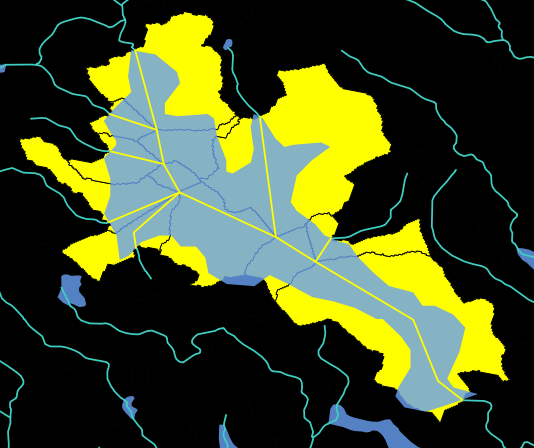

In [9]:
Image(filename='./images/linked.png')

# <font color='#1a3300'>Finding the difference of 2 geometries</font>
### <font color='#1a3300'>1. Start with a lake polygon</font>

(-1596000.0, -1591500.0, 1976000.0, 1983000.0)

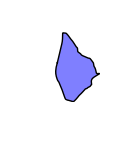

In [24]:
zone = '16'
lakes = gpd.GeoDataFrame.from_file('%s/NHDPlus%s/NHDWaterbodies.shp' % (DL_dir, zone)).to_crs({'init' :'epsg:5070'})
cats = gpd.GeoDataFrame.from_file('%s/NHDPlus%s/NHDCatchment.shp' % (DL_dir, zone)).to_crs({'init' :'epsg:5070'}) 
lake = lakes.ix[lakes.COMID == 22827340]
lake.plot(color='blue', figsize=(1,1)).axis('off')

### <font color='#1a3300'>2. Get it's associated catchment polygon(s), in this case, only one.</font>

(-1596000.0, -1590000.0, 1974000.0, 1980000.0)

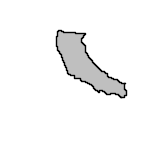

In [25]:
bsn = cats.ix[cats.FEATUREID == 11340401]
bsn.plot(color='gray', figsize=(1,1)).axis('off')

### <font color='#1a3300'>3. Plot them together, notice that the catchment doesn't completely cover the lake bounds</font>

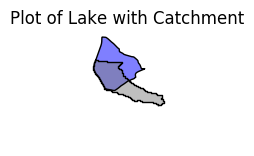

In [28]:
import matplotlib.pyplot as plt
#plt.style.use("default")
fig, ax = plt.subplots(1, figsize=(1,1))
base = lake.plot(ax=ax, color='blue')
bsn.plot(ax=base, color='grey') #
ax.axis('off')
ax.set_title("Plot of Lake with Catchment")

### <font color='#1a3300'>4. Isolate the difference</font>

(-1595500.0, -1591500.0, 1977000.0, 1983000.0)

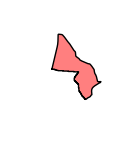

In [27]:
diffgeom = lake['geometry'].difference(bsn.unary_union.buffer(0))
diffgeom.plot(color='red', figsize=(1,1)).axis('off')

### <font color='#1a3300'>5. Using the area of this geometry, the resulting webmap plots instances where > 20% of the lake is uncovered by the associated catchment(s) bounds</font>

## For a IPython notebook demonstration of geopandas and folium packages, click [here](https://anaconda.org/debboutr/nhdlakesexercise/notebook)

> ### <font color='#1a3300'>"Many drops make a bucket, many buckets make a pond, many ponds make a lake, and many lakes make an ocean." - Percy Ross</font>

In [23]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<b><a href="javascript:code_toggle()">:)</a></b>''')